# Bifurcation analysis

Code functions from [Guilhem Doulcier lecture notes notebook](https://www.normalesup.org/~doulcier/teaching/modeling/bistable_systems.html).

In [1]:
from functools import partial 
from collections import defaultdict 
import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate #Integration library
from mpl_toolkits.mplot3d import axes3d #Used for the 3d bifurcation plot
import matplotlib.patches as mpatches #used to write custom legends
from matplotlib.lines import Line2D
# %matplotlib inline

## Definitions

In [2]:
from scipy.optimize import fsolve, root
import scipy.optimize
import matplotlib.patches as mpatches

EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center (Hopf)':'C5',
                    'Transcritical (Saddle-Node)':'C6'}

STABILITY_STYLE = {
    "Stable node": "-",
    "Stable focus": "-",
    "Unstable node": "--",
    "Unstable focus": "--",
    "Saddle": ":",
    "Center (Hopf)": "-.",
    "Transcritical (Saddle-Node)": "--"
}


def findroot(func, init): 
    """ Find root of equation function(x)=0
    Args:
        - the system (function),
        - the initial values (type list or np.array)

    return: correct equilibrium (type np.array) 
            if the numerical method converge or return nan
    """
    sol, info, convergence, sms = scipy.optimize.fsolve(func, init, full_output=1)
    if convergence == 1:
        return sol
    return np.array([np.nan]*len(init))
def numerical_continuation(f, initial_u, lbda_values):
    """ Find the roots of the parametrised non linear equation.  
    
    Iteratively find approximate solutions of `F(u, lambda) = 0` 
    for several values of lambda. The solution of the step i is
    used as initial guess for the numerical solver at step i+1. 
    The first inital guess is initial_u (for lbda_values[0]).        
    
    Args:
        f (function): Function of u and lambda.
        initial_u (float): Starting point for the contiunation.
        lbda_values (array): Values of the parameter lambda (in the order of the continuation process).
    
    Return: 
        (numpy.array) output[i] is the solutions of f(u,lbda_values[i]) = 0
         NaN if the algorithm did not converge.
    """
    eq = []
    for lbda in lbda_values:
        eq.append(findroot(lambda x: f(x,lbda),
                           eq[-1] if eq else initial_u))
    return eq


def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point 
    """
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant,0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature
def get_segments(values):
    """Return a dict listing the interval where values is constant.
    Return:
        A dict mapping (start, finish) index to value"""
    start = 0
    segments = {}
    for i,val in enumerate(values[1:],1):
        if val != values[start] or i == len(values)-1:
            segments[(start,i)] = values[start]
            start = i
    return segments

def plot_bifurcation(ax, branches, lbdaspace):
    """Function to draw nice bifurcation graph
    Args:
        ax: object of the plt.subplots
        branches: a list of two lists giving the position and
        the nature of the equilibrium.
        lbda_space: bifurcation parameter space
    """
    labels = frozenset()
    for eq, nature in branches:
        labels = labels.union(frozenset(nature))
        segments = get_segments(nature)
        print(eq, nature)
        for idx, n in segments.items():
            ax.plot(lbdaspace[idx[0]:idx[1]],eq[idx[0]:idx[1]],
                     color=EQUILIBRIUM_COLOR[n] if n in EQUILIBRIUM_COLOR else 'k')
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels],
              labels)
    



def get_branches(func, starting_points, lbda_space, jac):
    branches = []
    for init in starting_points:
        # Perform numerical continuation. 
        eq = numerical_continuation(func, np.array(init), lbda_space)
        nature = [stability(jac(u, lbda))
                  for (u, lbda) in zip(eq,lbda_space)]
        branches.append((np.array([x[0] for x in eq]),
                         nature))
    return branches

def get_branches(func, starting_points, lbda_space, jac, index=0):
    branches = []
    for init in starting_points:
        eq = numerical_continuation(func, np.array(init), lbda_space)
        nature = [stability(jac(u, lbda)) for (u, lbda) in zip(eq, lbda_space)]
        branch = np.array([x[index] for x in eq])
        branches.append((branch, nature))
    return branches 

def branch_switching(func, jac, u_b, lbda, epsilon=5e-1):
    J = jac(u_b, lbda)
    eigvals, eigvecs = np.linalg.eig(J)
    idx = np.argmin(np.abs(eigvals))  # Busca el eigenvalor más cercano a 0
    v = eigvecs[:, idx]
    v = v / np.linalg.norm(v)
    u_plus = u_b + epsilon * v
    u_minus = u_b - epsilon * v
    return u_plus, u_minus


# def branch_switching(func, jac, u_b, lbda, epsilon=5e-1):
#     J = jac(u_b, lbda)
    
#     # Verificar si la matriz contiene NaN o infinitos
#     if not np.isfinite(J).all():
#         print(f"Advertencia: La matriz jacobiana contiene valores no finitos en u_b={u_b}, lbda={lbda}")
#         # Intentar corregir la matriz reemplazando NaN/inf con valores pequeños
#         J = np.nan_to_num(J, nan=1e-10, posinf=1e10, neginf=-1e10)
        
#     try:
#         eigvals, eigvecs = np.linalg.eig(J)
#         idx = np.argmin(np.abs(eigvals))  # Busca el eigenvalor más cercano a 0
#         v = eigvecs[:, idx]
#         v = v / np.linalg.norm(v)
#         u_plus = u_b + epsilon * v
#         u_minus = u_b - epsilon * v
#         return u_plus, u_minus
#     except np.linalg.LinAlgError as e:
#         print(f"Error en el cálculo de autovalores: {e}")
#         print(f"Usando vector de perturbación aleatorio en su lugar")
#         # Usar un vector aleatorio normalizado como alternativa
#         v = np.random.rand(len(u_b))
#         v = v / np.linalg.norm(v)
#         u_plus = u_b + epsilon * v
#         u_minus = u_b - epsilon * v
#         return u_plus, u_minus
    
    

def get_branches(func, starting_points, lbda_space, jac, index=0, epsilon=5e-2):
    branches = []
    for init in starting_points:
        branch = numerical_continuation(func, np.array(init), lbda_space)
        nature = [stability(jac(u, lbda)) for (u, lbda) in zip(branch, lbda_space)]
        print("Starting point:", init)
        print("Stability sequence:", nature)
        branch_proj = np.array([x[index] for x in branch])
        bif_index = None
        for i in range(1, len(nature)):
            if nature[i] != nature[i-1]:
                bif_index = i
                break
        if bif_index is not None:
            u_b = branch[bif_index]
            lbda_b = lbda_space[bif_index]
            print("Bifurcation detectada en lambda =", lbda_b, "u =", u_b)
            # Se realizan dos continuaciones a partir de los nuevos starting points
            u_plus, u_minus = branch_switching(func, jac, u_b, lbda_b, epsilon)
            branch_plus = numerical_continuation(func, u_plus, lbda_space[bif_index:])
            branch_minus = numerical_continuation(func, u_minus, lbda_space[bif_index:])
            proj_plus = np.array([sol[index] for sol in branch_plus])
            proj_minus = np.array([sol[index] for sol in branch_minus])
            # Se añade la parte previa a la bifurcación a ambas ramas
            pre_bifurcation = branch_proj[:bif_index]
            nature_pre = nature[:bif_index]
            full_branch_plus = np.concatenate([pre_bifurcation, proj_plus])
            full_nature_plus = nature_pre + nature[bif_index:]
            full_branch_minus = np.concatenate([pre_bifurcation, proj_minus])
            full_nature_minus = nature_pre + nature[bif_index:]
            branches.append((full_branch_plus, full_nature_plus))
            branches.append((full_branch_minus, full_nature_minus))
        else:
            branches.append((branch_proj, nature))
    return branches

def find_unique_equilibria(flow, starting_points):
    '''Return the list of unique equilibria of a flow 
    starting around starting_points'''
    equilibria = [] 
    roots = [findroot(flow, init) 
             for init in starting_points]
    # Only keep unique equilibria 
    for r in roots:
        if (not any(np.isnan(r)) and
            not any([all(np.isclose(r, x)) for x in equilibria])):
            equilibria.append(r)
    return equilibria

def get_branches(func, starting_points, lbda_space, jac, index=0, epsilon=5e-2):
    branches = []
    for init in starting_points:
        branch = numerical_continuation(func, np.array(init), lbda_space)
        nature = [stability(jac(u, lbda)) for (u, lbda) in zip(branch, lbda_space)]
        print("Starting point:", init)
        print("Stability sequence:", nature)
        branch_proj = np.array([x[index] for x in branch])
        bif_index = None
        for i in range(1, len(nature)):
            if nature[i] != nature[i-1]:
                bif_index = i
                break
        if bif_index is not None:
            u_b = branch[bif_index]
            lbda_b = lbda_space[bif_index]
            print("Bifurcación detectada en lambda =", lbda_b, "u =", u_b)
            
            # Se realizan continuaciones a partir de los nuevos starting points
            u_plus, u_minus = branch_switching(func, jac, u_b, lbda_b, epsilon)
            
            # Continuación hacia adelante (forward)
            branch_plus_forward = numerical_continuation(func, u_plus, lbda_space[bif_index:])
            branch_minus_forward = numerical_continuation(func, u_minus, lbda_space[bif_index:])
            
            # Continuación hacia atrás (backward)
            lbda_space_backward = lbda_space[:bif_index+1][::-1]  # Invertimos el espacio lambda
            branch_plus_backward = numerical_continuation(func, u_plus, lbda_space_backward)
            branch_minus_backward = numerical_continuation(func, u_minus, lbda_space_backward)
            
            # Proyectamos las soluciones
            proj_plus_forward = np.array([sol[index] for sol in branch_plus_forward])
            proj_minus_forward = np.array([sol[index] for sol in branch_minus_forward])
            proj_plus_backward = np.array([sol[index] for sol in branch_plus_backward])
            proj_minus_backward = np.array([sol[index] for sol in branch_minus_backward])
            
            # Invertimos las soluciones backward para mantener el orden correcto
            proj_plus_backward = proj_plus_backward[::-1]
            proj_minus_backward = proj_minus_backward[::-1]
            
            # Construimos las ramas completas (backward + forward)
            full_branch_plus = np.concatenate([proj_plus_backward[:-1], proj_plus_forward])  # Evitamos duplicar el punto de bifurcación
            full_branch_minus = np.concatenate([proj_minus_backward[:-1], proj_minus_forward])
            
            # Calculamos la estabilidad para las nuevas ramas completas
            # Calculamos la estabilidad para cada punto en las nuevas ramas
            nature_backward_plus = [stability(jac(u, lbda)) for (u, lbda) in zip(branch_plus_backward, lbda_space_backward)]
            nature_backward_minus = [stability(jac(u, lbda)) for (u, lbda) in zip(branch_minus_backward, lbda_space_backward)]
            nature_forward_plus = [stability(jac(u, lbda)) for (u, lbda) in zip(branch_plus_forward, lbda_space[bif_index:])]
            nature_forward_minus = [stability(jac(u, lbda)) for (u, lbda) in zip(branch_minus_forward, lbda_space[bif_index:])]
            
            # Invertimos las naturalezas backward para mantener el orden correcto
            nature_backward_plus = nature_backward_plus[::-1]
            nature_backward_minus = nature_backward_minus[::-1]
            
            full_nature_plus = nature_backward_plus[:-1] + nature_forward_plus
            full_nature_minus = nature_backward_minus[:-1] + nature_forward_minus
            
            branches.append((full_branch_plus, full_nature_plus))
            branches.append((full_branch_minus, full_nature_minus))
        else:
            branches.append((branch_proj, nature))
    return branches

def branch_switching(func, jac, u_b, lbda, epsilon=5e-1):
    J = jac(u_b, lbda)
    
    # Check if J contains any inf or NaN values
    if not np.isfinite(J).all():
        print(f"Warning: Jacobian contains inf or NaN values at u_b={u_b}, lbda={lbda}")
        # Try to regularize the Jacobian
        J = np.nan_to_num(J, nan=1e-10, posinf=1e10, neginf=-1e10)
        
        # If still not finite after regularization, use a small perturbation
        if not np.isfinite(J).all():
            print("Attempting to perturb the equilibrium point slightly")
            delta = 1e-6
            u_b_perturbed = u_b + delta * np.random.randn(*u_b.shape)
            J = jac(u_b_perturbed, lbda)
            
            # If still problematic, return None to indicate failure
            if not np.isfinite(J).all():
                print("Cannot compute valid Jacobian. Skipping branch switching.")
                return None, None
    
    try:
        eigvals, eigvecs = np.linalg.eig(J)
        idx = np.argmin(np.abs(eigvals))  # Busca el eigenvalor más cercano a 0
        v = eigvecs[:, idx]
        
        # Normalize the eigenvector
        v = v / np.linalg.norm(v)
        
        # Compute the new branches
        u_plus = u_b + epsilon * v
        u_minus = u_b - epsilon * v
        
        return u_plus, u_minus
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError during eigenvalue computation: {e}")
        return None, None
# def get_branches(func, starting_points, lbda_space, jac, index=0, epsilon=5e-2):
#     branches = []
#     for init in starting_points:
#         branch = numerical_continuation(func, np.array(init), lbda_space)
#         nature = [stability(jac(u, lbda)) for (u, lbda) in zip(branch, lbda_space)]
#         print("Starting point:", init)
#         print("Stability sequence:", nature)
#         branch_proj = np.array([x[index] for x in branch])
#         bif_index = None
#         for i in range(1, len(nature)):
#             if nature[i] != nature[i-1]:
#                 bif_index = i
#                 break
#         if bif_index is not None:
#             u_b = branch[bif_index]
#             lbda_b = lbda_space[bif_index]
#             print("Bifurcación detectada en lambda =", lbda_b, "u =", u_b)
            
#             try:
#                 # Se realizan continuaciones a partir de los nuevos starting points
#                 u_plus, u_minus = branch_switching(func, jac, u_b, lbda_b, epsilon)
                
#                 # Continuación hacia adelante (forward)
#                 branch_plus_forward = numerical_continuation(func, u_plus, lbda_space[bif_index:])
#                 branch_minus_forward = numerical_continuation(func, u_minus, lbda_space[bif_index:])
                
#                 # Proyectamos las soluciones
#                 proj_plus_forward = np.array([sol[index] for sol in branch_plus_forward])
#                 proj_minus_forward = np.array([sol[index] for sol in branch_minus_forward])
                
#                 # Usamos la estabilidad original para la parte posterior a la bifurcación
#                 # Asumimos que una rama mantiene la estabilidad original y la otra cambia
#                 nature_forward_plus = nature[bif_index:]
#                 nature_forward_minus = [nature[bif_index-1]] * len(lbda_space[bif_index:])
                
#                 # Construimos las ramas completas
#                 branches.append((proj_plus_forward, nature_forward_plus))
#                 branches.append((proj_minus_forward, nature_forward_minus))
                
#             except Exception as e:
#                 print(f"Error en branch switching: {e}")
#                 # Si hay error, simplemente añadimos la rama original
#                 branches.append((branch_proj, nature))
#         else:
#             branches.append((branch_proj, nature))
#     return branches


# def get_branches(func, starting_points, lbda_space, jac,
#                  index=0, epsilon=5e-1):
#     """
#     - Continua forward sobre todo lbda_space.
#     - Detecta la primera bifurcación (cambio de estabilidad).
#     - En u_bif, lam_bif: branch_switching → u_plus, u_minus.
#     - Para cada uno, continua:
#          • forward en lbda_space[bif_idx:]       (incluye lam_bif)
#          • backward en lbda_space[:bif_idx+1][::-1]  (incluye lam_bif)
#     - Ensambla la parte pre-bifurcación solo en la rama forward.
#     """

#     branches = []

#     for init in starting_points:
#         # ——————————————————————————————————————————————
#         # 1) Ramo “principal” hacia adelante
#         U_main    = numerical_continuation(func, np.array(init), lbda_space)
#         N_main    = [stability(jac(u, lam)) 
#                      for u, lam in zip(U_main, lbda_space)]
#         P_main    = np.array([u[index] for u in U_main])

#         # 2) Busca el índice de la PRIMERA bifurcación
#         bif_idx = next(
#             (i for i in range(1, len(N_main))
#              if N_main[i] != N_main[i-1]),
#             None
#         )
#         # si no hay bif, guardamos la rama tal cual
#         if bif_idx is None:
#             branches.append((P_main, N_main))
#             continue

#         # 3) Punto de bifurcación
#         u_bif = U_main[bif_idx]
#         lam_bif = lbda_space[bif_idx]
#         print("Bifurcación en λ =", lam_bif, "u =", u_bif)

#         # 4) Branch switching: dos nuevos estados en (u_bif, lam_bif)
#         u_plus, u_minus = branch_switching(func, jac, u_bif, lam_bif, epsilon)

#         # 5) Definición de secuencias LAMBDA para seguir cada semirrama
#         lam_fwd = lbda_space[bif_idx:]           # [λ_bif, λ_{bif+1}, ...]
#         lam_bwd = lbda_space[:bif_idx+1][::-1]   # [λ_bif, λ_{bif-1}, ..., λ_0]

#         def cont_proj(u0, lam_seq):
#             """Hace numerical_continuation sobre lam_seq, 
#                y devuelve (proyecciones, naturalezas)."""
#             U = numerical_continuation(func, u0, lam_seq)
#             P = np.array([u[index] for u in U])
#             N = [stability(jac(u, lam)) for u, lam in zip(U, lam_seq)]
#             return P, N

#         # partes anteriores a bif (solo para forward)
#         pre_P = P_main[:bif_idx]
#         pre_N = N_main[:bif_idx]

#         # 6) Para cada semirrama (+ y –) lanzo forward y backward
#         for u0 in (u_plus, u_minus):
#             # — forward
#             Pf, Nf = cont_proj(u0, lam_fwd)
#             full_Pf = np.concatenate([pre_P, Pf])
#             full_Nf =       pre_N  + Nf
#             branches.append((full_Pf, full_Nf))

#             # — backward
#             Pb, Nb = cont_proj(u0, lam_bwd)
#             # (empezará en lam_bif y seguirá λ decreciente)
#             branches.append((Pb, Nb))

#     return branches




# def plot_bifurcation(ax, branches, lbdaspace):
#     cmap = plt.cm.get_cmap('tab10')
#     n_branches = len(branches)
#     colors = [cmap(i) for i in np.linspace(0, 1, n_branches)]
    
#     stability_set = set()
    
#     for i, (branch, nature) in enumerate(branches):
#         branch_color = colors[i]
#         segments = get_segments(nature)
#         for (start, finish), stab in segments.items():
#             ls = STABILITY_STYLE.get(stab, "-")
#             stability_set.add(stab)
#             ax.plot(lbdaspace[start:finish], branch[start:finish],
#                     color=branch_color, linestyle=ls, linewidth=2)
#         ax.scatter(lbdaspace[0], branch[0], color=branch_color, s=50, zorder=5)
    
#     legend_elements = []
#     for stab in sorted(stability_set):
#         ls = STABILITY_STYLE.get(stab, "-")
#         legend_elements.append(Line2D([0], [0], color='black', linestyle=ls, lw=2, label=stab))
    
#     ax.legend(handles=legend_elements, title="Estabilidad")




In [ ]:
import sympy as sp

X1, X2 = sp.symbols('X1 X2')
tau, phi_p, phi_pp, phi_ppp, s0, c,g, phi_Ip = sp.symbols('tau phi_p phi_pp phi_ppp s0 c g phi_Ip')
I_L, I_C, I_R, s_L, s_C, s_R, R, I_I, I0, R_I = sp.symbols('I_L I_C I_R s_L s_C s_R R I_I, I0, R_I')

# Definimos los componentes del campo vectorial (parte determinista, sin ruido)
F1 = -(
    (phi_p/2)*(I_L - I_C + X1*(s_L+s_C) + (R+X2)*(s_L-s_C)) +
    (s0*phi_pp/2)*(
         R*(s_L+s_C) + I_L + I_C + (2*(s0-c*g*phi_Ip))/(3*c*g*phi_Ip)*(I_L+I_C+I_R + R*(s_L+s_C+s_R))
    )*X1 +
    (s0*phi_pp/2)*(R*(s_L-s_C) + I_L - I_C)*X2 +
    s0**2 * phi_pp * X1*X2 +
    ((s0-c*g*phi_Ip)/(3*c*g*phi_Ip))* s0**3 * (phi_pp**2) * X1*(X1**2+3*X2**2) +
    (phi_ppp*s0**3/6)* X1*(X1**2+3*X2**2)
)

F2 = -3*(
    (phi_p/6)*(X1*(s_L-s_C) + X2*(s_L+s_C+4*s_R) + I_L + I_C - 2*I_R + R*(s_L+s_C-2*s_R)) +
    (s0*phi_pp/6)*(
         R*(s_L+s_C+4*s_R) + (I_L+I_C+4*I_R) + ((s0-c*g*phi_Ip)/(2*c*g*phi_Ip))*(I_L+I_C+I_R + R*(s_L+s_C+s_R))
    )*X2 +
    (s0*phi_pp/6)*(R*(s_L-s_C) + I_L - I_C)*X1 +
    (s0**2 * phi_pp/6)*(X1**2-3*X2**2) +
    ((s0-c*g*phi_Ip)/(3*c*g*phi_Ip))* s0**3 * (phi_pp**2) * X2*(X1**2+3*X2**2) +
    (phi_ppp*s0**3/6)* X2*(X1**2+3*X2**2)
)


s0_val = 1
IL_val, IC_val, IR_val, I_I_val = 0,0,0,1/3
sL_val, sC_val, sR_val = 0,0,0
R_val = 1/4
I0_val = 1/2
c_val = 1        
g_val = 1  
R_I_val = 1/4
# I_I = 1/2


x = sp.symbols('x', real=True)
# s0, R, R_I, I0, c = sp.symbols('s0 R R_I I0 c', real=True)

phi = sp.Piecewise(
    (0, x < 0),
    (x**2, sp.And(x >= 0, x <= 1)),
    (2*sp.sqrt(x - sp.Rational(3, 4)), x > 1)
)

phi_prime = sp.diff(phi, x)
phi_double_prime = sp.diff(phi_prime, x)
phi_triple_prime = sp.diff(phi_double_prime, x)

X0 = s0*R - c*R_I + I0
X0_I = g*R+I_I




phi_X0 = sp.simplify(phi.subs(x, X0).subs({s0:s0_val, R:R_val, R_I:R_I_val, I0:I0_val, c:c_val}))
phi_prime_X0 = sp.simplify(phi_prime.subs(x, X0).subs({s0:s0_val, R:R_val, R_I:R_I_val, I0:I0_val, c:c_val}))
phi_double_prime_X0 = sp.simplify(phi_double_prime.subs(x, X0).subs({s0:s0_val, R:R_val, R_I:R_I_val, I0:I0_val, c:c_val}))
phi_triple_prime_X0 = sp.simplify(phi_triple_prime.subs(x, X0).subs({s0:s0_val, R:R_val, R_I:R_I_val, I0:I0_val, c:c_val}))
phi_I_prime = sp.simplify(phi_prime.subs(x, X0_I).subs({g: g_val, R_I:R_I_val, I_I:I_I_val, c:c_val, R:R_val}))

print(phi_I_prime)

F1 = F1.subs({
    s0: s0_val,
    # I_L: IL_val,
    # I_C: IC_val,
    # I_R: IR_val,
    I_I: I_I_val,
    s_L: sL_val,
    s_C: sC_val,
    s_R: sR_val,
    R: R_val,
    c: c_val,
    g: g_val,
    I_I: I_I_val,
    phi_p: phi_prime_X0,
    phi_pp: phi_double_prime_X0,
    phi_ppp: phi_triple_prime_X0,
    phi_Ip: phi_I_prime
})
F2 = F2.subs({
    s0: s0_val,
    # I_L: IL_val,
    # I_C: IC_val,
    # I_R: IR_val,
    s_L: sL_val,
    s_C: sC_val,
    s_R: sR_val,
    R: R_val,
    c: c_val,
    g: g_val,
    I_I: I_I_val,
    phi_p: phi_prime_X0,
    phi_pp: phi_double_prime_X0,
    phi_ppp: phi_triple_prime_X0,
    phi_Ip: phi_I_prime
})

F1_b = F1.subs({
    I_L: IL_val,
    I_C: IC_val,
    I_R: IR_val,
})
F2_b = F2.subs({
    I_L: IL_val,
    I_C: IC_val,
    I_R: IR_val,
})


F1_num = sp.lambdify((X1, X2), F1.subs({I_L: IL_val, I_C: IC_val, I_R: IR_val}))
F2_num = sp.lambdify((X1, X2), F2.subs({I_L: IL_val, I_C: IC_val, I_R: IR_val}))


F1_iso = sp.solve(F1.subs({ I_L: IL_val, I_C: IC_val, I_R: IR_val, I_I: I_I_val}), X2)
F1_iso = sp.lambdify(X1,F1_iso)
F2_iso = sp.solve(F2.subs({ I_L: IL_val, I_C: IC_val, I_R: IR_val, I_I: I_I_val}), X1)
F2_iso = sp.lambdify(X2,F2_iso)

def F(params):
    X1, X2= params[0], params[1]
    return [F1_num(X1, X2), F2_num(X1, X2)]

F1_bif = sp.lambdify((X1, X2, I_L, I_C, I_R), -F1) 
F2_bif = sp.lambdify((X1, X2, I_L, I_C, I_R), -F2)
phi_prime.subs({x:0.5})

1.16666666666667


1.00000000000000

In [11]:
phi_X0 = sp.simplify(phi.subs(x, X0))
phi_prime_X0 = sp.simplify(phi_prime.subs(x, X0))
phi_I_prime = sp.simplify(phi_prime.subs(x, X0_I))
phi_I = sp.simplify(phi.subs(x, X0_I))

eq1 = s0*phi_prime_X0-1
eq2 = R - phi_X0 
eq3 = R_I - phi_I

print(sp.latex(eq1))
print(sp.latex(eq2))
print(sp.latex(eq3))
eq1 = eq1.subs({s0:s0_val, c:c_val, g:g_val, I_I:I_I_val})
eq2 = eq2.subs({s0:s0_val, c:c_val, g:g_val, I_I:I_I_val})
eq3 = eq3.subs({s0:s0_val, c:c_val, g:g_val, I_I:I_I_val})
eq3


s_{0} \left(\begin{cases} 0 & \text{for}\: I_{0} + R s_{0} - R_{I} c < 0 \\2 I_{0} + 2 R s_{0} - 2 R_{I} c & \text{for}\: I_{0} + R s_{0} - R_{I} c \leq 1 \\\frac{2}{\sqrt{4 I_{0} + 4 R s_{0} - 4 R_{I} c - 3}} & \text{otherwise} \end{cases}\right) - 1
R - \begin{cases} 0 & \text{for}\: I_{0} + R s_{0} - R_{I} c < 0 \\\left(I_{0} + R s_{0} - R_{I} c\right)^{2} & \text{for}\: I_{0} + R s_{0} - R_{I} c \leq 1 \\\sqrt{4 I_{0} + 4 R s_{0} - 4 R_{I} c - 3} & \text{otherwise} \end{cases}
R_{I} - \begin{cases} 0 & \text{for}\: I_{I} + R g < 0 \\\left(I_{I} + R g\right)^{2} & \text{for}\: I_{I} + R g \leq 1 \\\sqrt{4 I_{I} + 4 R g - 3} & \text{otherwise} \end{cases}


R_I - Piecewise((0, R + 0.333333333333333 < 0), ((R + 0.333333333333333)**2, R + 0.333333333333333 <= 1), (sqrt(4*R - 1.66666666666667), True))

In [5]:

# sol_simbólica = sp.solve([eq1, eq2, eq3], [R, R_I, I0], dict=True)
F_so = sp.lambdify(
    (R, R_I, I0),
    (eq1, eq2, eq3),
    'numpy'
)

# 3) envoltorio para fsolve, fijando s0_val y c_val
def fun(vars):
    R_val, R_I_val, I0_val = vars
    return F_so(R_val, R_I_val, I0_val)


print(fun([1/4, 1/4, 1/2]))
# 4) resolución numérica
x0 = [1/4, 1/4, 1/2]  # tu guess
sol = fsolve(fun, x0)
print("solución:", sol)
# print("Solución simbólica:")
# print(sol_simbólica)

(0.0, 0.0, -0.09027777777777746)
solución: [0.25       0.34027778 0.59027778]


<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in sqrt
  return (select([less(I0 + R - R_I, 0),less_equal(I0 + R - R_I, 1),True], [0,2*I0 + 2*R - 2*R_I,2/sqrt(4*I0 + 4*R - 4*R_I - 3)], default=nan) - 1, R - select([less(I0 + R - R_I, 0),less_equal(I0 + R - R_I, 1),True], [0,(I0 + R - R_I)**2,sqrt(4*I0 + 4*R - 4*R_I - 3)], default=nan), R_I - select([less(R + 0.333333333333333, 0),less_equal(R + 0.333333333333333, 1),True], [0,(R + 0.333333333333333)**2,sqrt(4*R - 1.66666666666667)], default=nan),)


<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in sqrt
  return [1.73205080756888*X2*sqrt((-4.0*X2 - 7.0)/(4.0*X2 - 7.0)), -1.73205080756888*X2*sqrt(-(4.0*X2 + 7.0)/(4.0*X2 - 7.0))]


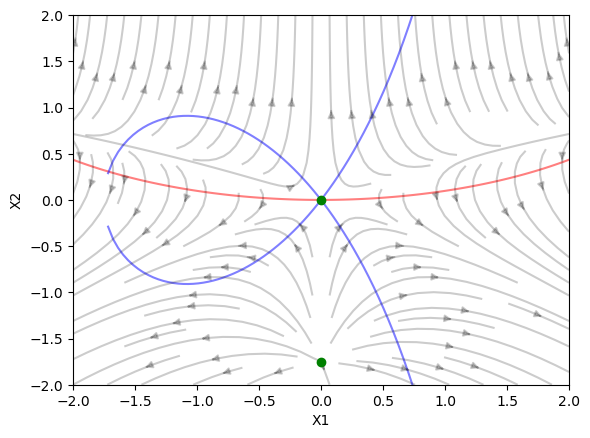

In [6]:
def plot_isocline(ax, uspace, color='k', style='--', opacity=.5):
    """Plot the isoclines of the symmetric cellular switch system"""
    ax.plot(uspace, F1_iso(uspace)[0], color='red', alpha=opacity)
    ax.plot(uspace, F1_iso(uspace)[1], color='red', alpha=opacity)
    ax.plot(uspace,F2_iso(uspace)[0],  color='blue', alpha=opacity)
    ax.plot(uspace,F2_iso(uspace)[1], color='blue', alpha=opacity)
    ax.set(xlabel='X1',ylabel='X2')

def plot_flow(ax, uspace, vspace):
    """Plot the flow of the symmetric cellular switch system"""
    X,Y = np.meshgrid(uspace,vspace)
    a = F([X,Y])   
    ax.streamplot(X,Y,a[0], a[1], color=(0,0,0,.2))
    ax.set(xlim=(uspace.min(),uspace.max()), ylim=(vspace.min(),vspace.max()))

equilibrium =sp.solve([F1_b, F2_b], (X1, X2), dict=True)
uspace = np.linspace(-2,2,100)
vspace = np.linspace(-2,2,100)
plot_isocline(plt.gca(), uspace)
plot_flow(plt.gca(), uspace, vspace)
for eq in equilibrium:
    plt.scatter(eq[X1], eq[X2], color='green', zorder=5)


## Animation

[{X1: 0.0, X2: 0.0}, {X1: 0.0, X2: -0.875 - 1.61535599791501*I}, {X1: 0.0, X2: -0.875 + 1.61535599791501*I}, {X1: -1.33819241071786 - 2.2891868152341*I, X2: 0.410714285714286 + 0.7624393585789*I}, {X1: -1.33819241071786 + 2.2891868152341*I, X2: 0.410714285714286 - 0.7624393585789*I}, {X1: 1.33819241071786 - 2.2891868152341*I, X2: 0.410714285714286 - 0.7624393585789*I}, {X1: 1.33819241071786 + 2.2891868152341*I, X2: 0.410714285714286 + 0.7624393585789*I}]
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., na

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
  return [0.0416666666666667*(-21.0*I_C + 21.0*I_L + 42.0*X1 - 1.73205080756888*sqrt(147.0*I_C**2 - 294.0*I_C*I_L + 304.0*I_C*X1**2 - 756.0*I_C*X1 + 147.0*I_L**2 + 304.0*I_L*X1**2 + 756.0*I_L*X1 - 32.0*I_R*X1**2 - 64.0*X1**4 + 588.0*X1**2))/X1, 0.0416666666666667*(-21.0*I_C + 21.0*I_L + 42.0*X1 + 1.73205080756888*sqrt(147.0*I_C**2 - 294.0*I_C*I_L + 304.0*I_C*X1**2 - 756.0*I_C*X1 + 147.0*I_L**2 + 304.0*I_L*X1**2 + 756.0*I_L*X1 - 32.0*I_R*X1**2 - 64.0*X1**4 + 588.0*X1**2))/X1]
<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in sqrt
  return [0.5*(-7.0*I_C + 7.0*I_L - sqrt(49.0*I_C**2 - 98.0*I_C*I_L + 104.0*I_C*X2**2 - 126.0*I_C*X2 - 98.0*I_C + 49.0*I_L**2 + 104.0*I_L*X2**2 - 126.0*I_L*X2 - 98.0*I_L + 440.0*I_R*X2**2 - 882.0*I_R*X2 + 196.0*I_R - 192.0*X2**4 + 588.0*X2**2))/(4.0*X2 - 7.0), 0.5*(-7.0*I_C + 7.0*I_L + sqrt(49.0*I_C**2 - 98.0*I_C*I_L + 104.0*I_C*X2**2 - 126.0*I_C*X2 - 98.0*I_C + 49.0*

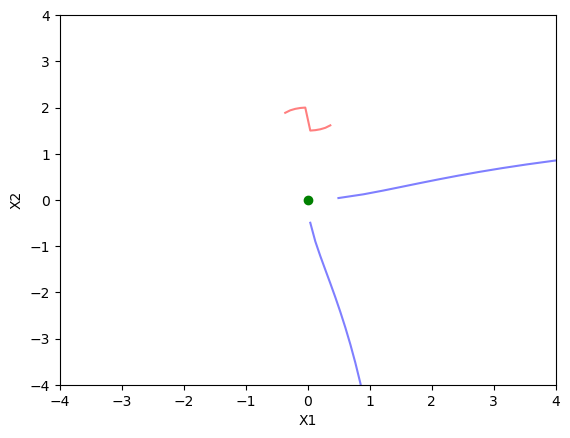

In [7]:
def plot_isocline(ax, uspace, I, color='k', style='--', opacity=.5):
   
    """Plot the isoclines of the symmetric cellular switch system"""
    ax.plot(uspace, F1_iso(uspace,I,I,I)[0], color='red', alpha=opacity)
    # ax.plot(uspace, F1_iso(uspace,I,I,I)[1], color='red', alpha=opacity)
    ax.plot(F2_iso(uspace,I,I,I)[0],uspace,  color='blue', alpha=opacity)
    ax.plot(uspace,F2_iso(uspace,I,I,I)[1], color='blue', alpha=opacity)
    ax.set(xlabel='X1',ylabel='X2')

def plot_flow(ax, uspace, vspace, I):
    """Plot the flow of the symmetric cellular switch system"""
    X,Y = np.meshgrid(uspace,vspace)
    a = F([X,Y], I)   
    print(a)
    ax.streamplot(X,Y,a[0], a[1], color=(0,0,0,.1))
    ax.set(xlim=(uspace.min(),uspace.max()), ylim=(vspace.min(),vspace.max()))


F1_iso = sp.solve(-F1, X2)
F1_iso = sp.lambdify((X1,I_L,I_C,I_R),F1_iso)
F2_iso = sp.solve(-F2, X1)
F2_iso = sp.lambdify((X2,I_L,I_C,I_R),F2_iso)
def F(params, I):
    X1, X2= params[0], params[1]
    return [F1_iso(X2, I,I,I)[0], F2_iso(X1,I,I,I)[0]]


uspace = np.linspace(-4,4,100)
vspace = np.linspace(-4,4,100)
I = -1

F1_b = F1.subs({
    I_L: I,
    I_C: I,
    I_R: I,
})
F2_b = F2.subs({
    I_L: I,
    I_C: I,
    I_R: I,
})
equilibrium =sp.solve([F1_b, F2_b], (X1, X2), dict=True)
print(equilibrium)
plot_isocline(plt.gca(), uspace,I)
plot_flow(plt.gca(), uspace, vspace, I)
for eq in equilibrium:
    if all(val.is_real for val in eq.values()):  # Ensure all values are real
        plt.scatter(float(eq[X1]), float(eq[X2]), color='green', zorder=5)
equilibrium = [eq for eq in equilibrium if all(val.is_real for val in eq.values())]

[(0.0, 0.0)]
Starting point: (0.0, 0.0)
Stability sequence: ['Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Unstable node', 'Uns

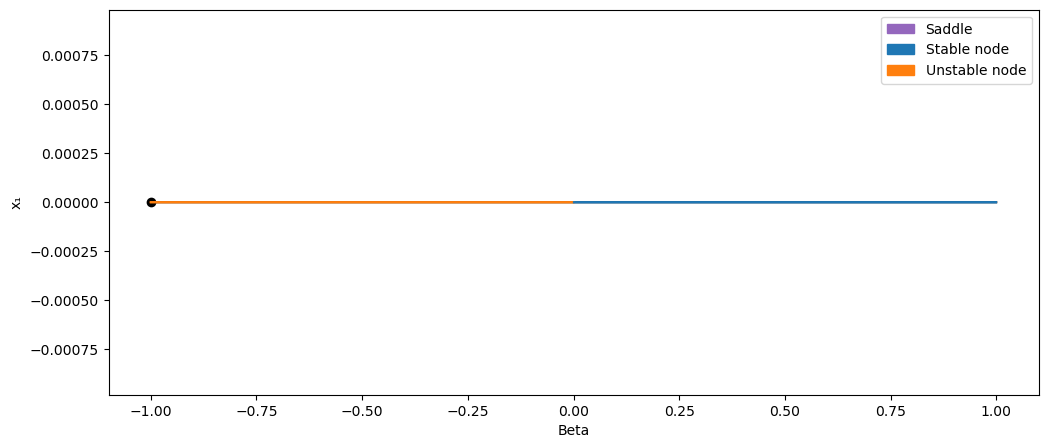

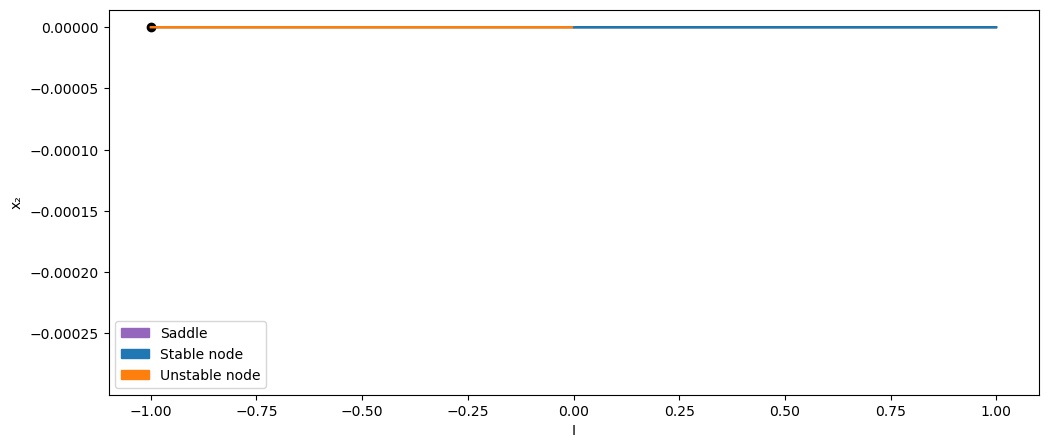

In [8]:
beta_space = np.linspace(-1,1,3000)

starting_points = [(float(eq[X1]), float(eq[X2])) for eq in equilibrium]
print(starting_points)
def sistema(vars, I):
    x1, x2 = vars  # Variables del estado
    return [F1_bif(x1, x2, I, I, I), F2_bif(x1, x2, I, I, I)]

f = sp.Matrix([F1, F2])
J = sp.simplify(f.jacobian([X1, X2]))

jacobian_function = sp.lambdify((X1, X2, I_L, I_C, I_R), J, 'numpy')
def jac(u, lbda):
    return jacobian_function(u[0], u[1], lbda, lbda, lbda)



fig, ax = plt.subplots(figsize=(12,5))
ax.set(xlabel='Beta', ylabel='x₁')
for init in starting_points:
    # Ploteo del punto de inicio
    ax.scatter(beta_space[0], init[0], color='k')
    # Continuación numérica usando el sistema completo
    eq_full = numerical_continuation(sistema, np.array(init), beta_space)
    x1_branch = [sol[0] for sol in eq_full]
    ax.plot(beta_space, x1_branch, color='k')
# (Opcional) Llamada para superponer la clasificación de estabilidad si se dispone de ella
branches = get_branches(sistema, starting_points, beta_space, jac, index=0)
plot_bifurcation(ax, branches, beta_space)

fig, ax = plt.subplots(figsize=(12,5))
ax.set(xlabel='I', ylabel='x₂')
for init in starting_points:
    ax.scatter(beta_space[0], init[1], color='k')
    eq_full = numerical_continuation(sistema, np.array(init), beta_space)
    x2_branch = [sol[1] for sol in eq_full]
    ax.plot(beta_space, x2_branch, color='k')
branches = get_branches(sistema, starting_points, beta_space, jac, index=1)

plot_bifurcation(ax, branches, beta_space)



Procesando I = -1.0
Procesando I = -0.9696969696969697
Procesando I = -0.9393939393939394
Procesando I = -0.9090909090909091
Procesando I = -0.8787878787878788
Procesando I = -0.8484848484848485
Procesando I = -0.8181818181818181
Procesando I = -0.7878787878787878
Procesando I = -0.7575757575757576
Procesando I = -0.7272727272727273
Procesando I = -0.696969696969697
Procesando I = -0.6666666666666666
Procesando I = -0.6363636363636364
Procesando I = -0.6060606060606061
Procesando I = -0.5757575757575757
Procesando I = -0.5454545454545454
Procesando I = -0.5151515151515151
Procesando I = -0.48484848484848486
Procesando I = -0.4545454545454546
Procesando I = -0.4242424242424242
Procesando I = -0.3939393939393939
Procesando I = -0.36363636363636365
Procesando I = -0.33333333333333326
Procesando I = -0.303030303030303
Procesando I = -0.2727272727272727
Procesando I = -0.24242424242424243
Procesando I = -0.21212121212121215
Procesando I = -0.18181818181818177
Procesando I = -0.1515151515151

/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
 solution is possible.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  sol = fsolve(ecuaciones, punto_inicial)


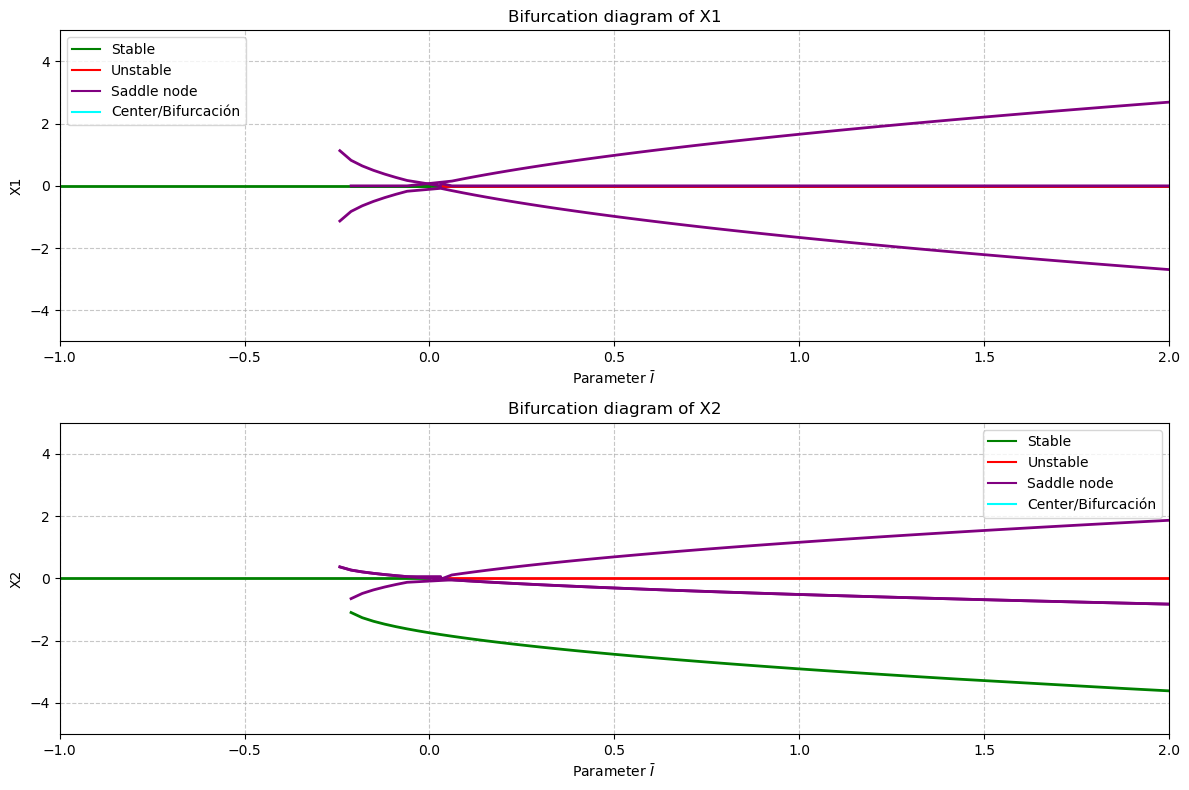

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.cm as cm

# Función para encontrar puntos de equilibrio (mantener la misma)
# ...

# Función para determinar la estabilidad (mantener la misma)
# ...
def encontrar_equilibrios(I_valor):
    """
    Encuentra los puntos de equilibrio para un valor específico de I.
    
    Args:
        I_valor: Valor del parámetro I
        
    Returns:
        Lista de puntos de equilibrio [X1, X2]
    """
    # Función para encontrar raíces (donde dX1/dt = dX2/dt = 0)
    def ecuaciones(X):
        X1, X2 = X
        dX1 = F1_bif(X1, X2, I_valor, I_valor, I_valor)
        dX2 = F2_bif(X1, X2, I_valor, I_valor, I_valor)
        return [dX1, dX2]
    
    # Intentamos con diferentes condiciones iniciales para encontrar todos los equilibrios
    puntos_iniciales = [
        [0.0, 0.0], [1.0, 0.0], [-1.0, 0.0], [0.0, 1.0], [0.0, -1.0],
        [1.0, 1.0], [-1.0, -1.0], [1.0, -1.0], [-1.0, 1.0],
        [2.0, 0.0], [-2.0, 0.0], [0.0, 2.0], [0.0, -2.0],
        [0.5, 0.5], [-0.5, -0.5], [0.5, -0.5], [-0.5, 0.5]
    ]
    
    equilibrios = []
    for punto_inicial in puntos_iniciales:
        try:
            sol = fsolve(ecuaciones, punto_inicial)
            # Verificamos si es realmente un equilibrio
            residuo = np.sum(np.abs(ecuaciones(sol)))
            if residuo < 1e-8:
                # Verificamos si este equilibrio ya está en la lista
                es_nuevo = True
                for eq in equilibrios:
                    if np.linalg.norm(np.array(sol) - np.array(eq)) < 1e-6:
                        es_nuevo = False
                        break
                if es_nuevo:
                    equilibrios.append(sol)
        except:
            continue
    
    return equilibrios



def determinar_estabilidad(X_eq, I_valor):

    X1, X2 = X_eq
    
    h = 1e-6
    J11 = (F1_bif(X1 + h, X2, I_valor, I_valor, I_valor) - F1_bif(X1, X2, I_valor, I_valor, I_valor)) / h
    J12 = (F1_bif(X1, X2 + h, I_valor, I_valor, I_valor) - F1_bif(X1, X2, I_valor, I_valor, I_valor)) / h
    J21 = (F2_bif(X1 + h, X2, I_valor, I_valor, I_valor) - F2_bif(X1, X2, I_valor, I_valor, I_valor)) / h
    J22 = (F2_bif(X1, X2 + h, I_valor, I_valor, I_valor) - F2_bif(X1, X2, I_valor, I_valor, I_valor)) / h
    
    J = np.array([[J11, J12], [J21, J22]])
    vaps = np.linalg.eigvals(J)
    partes_reales = np.real(vaps)
    if np.all(partes_reales < 0):
        if np.any(np.abs(np.imag(vaps)) > 1e-10):
            return "stable focus"
        else:
            return "stable node"
    elif np.all(partes_reales > 0):
        if np.any(np.abs(np.imag(vaps)) > 1e-10):
            return "unstable focus"
        else:
            return "unstable node"
    elif np.any(partes_reales < 0) and np.any(partes_reales > 0):
        return "saddle node"
    elif np.any(np.abs(partes_reales) < 1e-10):
        return "center"
    else:
        return "Unknown stability"
    
def diagrama_bifurcacion_lineas(I_min=-2.0, I_max=2.0, num_I_values=100):
    I_values = np.linspace(I_min, I_max, num_I_values)
    ramas = {
        'stable': [],
        'unstable': [],
        'saddle': [],
        'center': []
    }
    
    for i, I in enumerate(I_values):
        print(f"Procesando I = {I}")
        equilibrios = encontrar_equilibrios(I)
        
        if i == 0:
            for j, eq in enumerate(equilibrios):
                estabilidad = determinar_estabilidad(eq, I)
                
                if "stable" in estabilidad and "unstable" not in estabilidad:
                    ramas['stable'].append({'puntos': [(I, eq[0], eq[1])], 'id': f'stable_{j}'})
                elif "unstable" in estabilidad:
                    ramas['unstable'].append({'puntos': [(I, eq[0], eq[1])], 'id': f'unstable_{j}'})
                elif "saddle" in estabilidad:
                    ramas['saddle'].append({'puntos': [(I, eq[0], eq[1])], 'id': f'saddle_{j}'})
                else:
                    ramas['center'].append({'puntos': [(I, eq[0], eq[1])], 'id': f'center_{j}'})
        else:
            for eq in equilibrios:
                estabilidad = determinar_estabilidad(eq, I)
                tipo = None
                if "stable" in estabilidad and "unstable" not in estabilidad:
                    tipo = 'stable'
                elif "unstable" in estabilidad:
                    tipo = 'unstable'
                elif "saddle" in estabilidad:
                    tipo = 'saddle'
                else:
                    tipo = 'center'
                min_dist = float('inf')
                rama_cercana = None
                
                for rama in ramas[tipo]:
                    ultimo_punto = rama['puntos'][-1]
                    _, x1_ultimo, x2_ultimo = ultimo_punto
                    
                    dist = np.sqrt((eq[0] - x1_ultimo)**2 + (eq[1] - x2_ultimo)**2)
                    
                    if dist < min_dist:
                        min_dist = dist
                        rama_cercana = rama
                
                if rama_cercana is not None and min_dist < 1.0:  
                    rama_cercana['puntos'].append((I, eq[0], eq[1]))
                else:
                    nuevo_id = f'{tipo}_{len(ramas[tipo])}'
                    ramas[tipo].append({'puntos': [(I, eq[0], eq[1])], 'id': nuevo_id})
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    
    colores = {
        'stable': 'green',
        'unstable': 'red',
        'saddle': 'purple',
        'center': 'cyan'
    }
    
    for tipo, lista_ramas in ramas.items():
        for rama in lista_ramas:
            puntos = rama['puntos']
            if len(puntos) > 1:  
                I_rama = [p[0] for p in puntos]
                X1_rama = [p[1] for p in puntos]
                
                idx = np.argsort(I_rama)
                I_rama = [I_rama[i] for i in idx]
                X1_rama = [X1_rama[i] for i in idx]
                
                plt.plot(I_rama, X1_rama, '-', color=colores[tipo], linewidth=2)
            elif len(puntos) == 1:  
                plt.plot(puntos[0][0], puntos[0][1], 'o', color=colores[tipo], markersize=4)
    
    plt.title('Bifurcation diagram of X1')
    plt.xlabel(r'Parameter $\bar{I}$')
    plt.ylabel('X1')
    plt.xlim(I_min, I_max)
    plt.ylim(-5, 5)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Leyenda
    plt.plot([], [], '-', color='green', label='Stable')
    plt.plot([], [], '-', color='red', label='Unstable')
    plt.plot([], [], '-', color='purple', label='Saddle node')
    plt.plot([], [], '-', color='cyan', label='Center/Bifurcación')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    
    for tipo, lista_ramas in ramas.items():
        for rama in lista_ramas:
            puntos = rama['puntos']
            if len(puntos) > 1:  
                I_rama = [p[0] for p in puntos]
                X2_rama = [p[2] for p in puntos]
                
                
                idx = np.argsort(I_rama)
                I_rama = [I_rama[i] for i in idx]
                X2_rama = [X2_rama[i] for i in idx]
                
                plt.plot(I_rama, X2_rama, '-', color=colores[tipo], linewidth=2)
            elif len(puntos) == 1: 
                plt.plot(puntos[0][0], puntos[0][2], 'o', color=colores[tipo], markersize=4)
    
    plt.title('Bifurcation diagram of X2')
    plt.xlabel(r'Parameter $\bar{I}$')
    plt.ylabel('X2')
    plt.xlim(I_min, I_max)
    plt.ylim(-5, 5)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Leyenda
    plt.plot([], [], '-', color='green', label='Stable')
    plt.plot([], [], '-', color='red', label='Unstable')
    plt.plot([], [], '-', color='purple', label='Saddle node')
    plt.plot([], [], '-', color='cyan', label='Center/Bifurcación')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('diagrama_bifurcacion_lineas.png', dpi=300)
    plt.show()

# Ejemplo de uso
diagrama_bifurcacion_lineas(I_min=-1.0, I_max=2.0, num_I_values=100)

Procesando I = -1.0
Procesando I = -0.9696969696969697
Procesando I = -0.9393939393939394
Procesando I = -0.9090909090909091
Procesando I = -0.8787878787878788
Procesando I = -0.8484848484848485
Procesando I = -0.8181818181818181
Procesando I = -0.7878787878787878
Procesando I = -0.7575757575757576
Procesando I = -0.7272727272727273
Procesando I = -0.696969696969697
Procesando I = -0.6666666666666666
Procesando I = -0.6363636363636364
Procesando I = -0.6060606060606061
Procesando I = -0.5757575757575757
Procesando I = -0.5454545454545454
Procesando I = -0.5151515151515151
Procesando I = -0.48484848484848486
Procesando I = -0.4545454545454546
Procesando I = -0.4242424242424242
Procesando I = -0.3939393939393939
Procesando I = -0.36363636363636365
Procesando I = -0.33333333333333326
Procesando I = -0.303030303030303
Procesando I = -0.2727272727272727
Procesando I = -0.24242424242424243
Procesando I = -0.21212121212121215
Procesando I = -0.18181818181818177
Procesando I = -0.1515151515151

/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
 solution is possible.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  sol = fsolve(ecuaciones, punto_inicial)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_3967/2728343680.py:40: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  sol = fsolve(ecuaciones, punto_inicial)


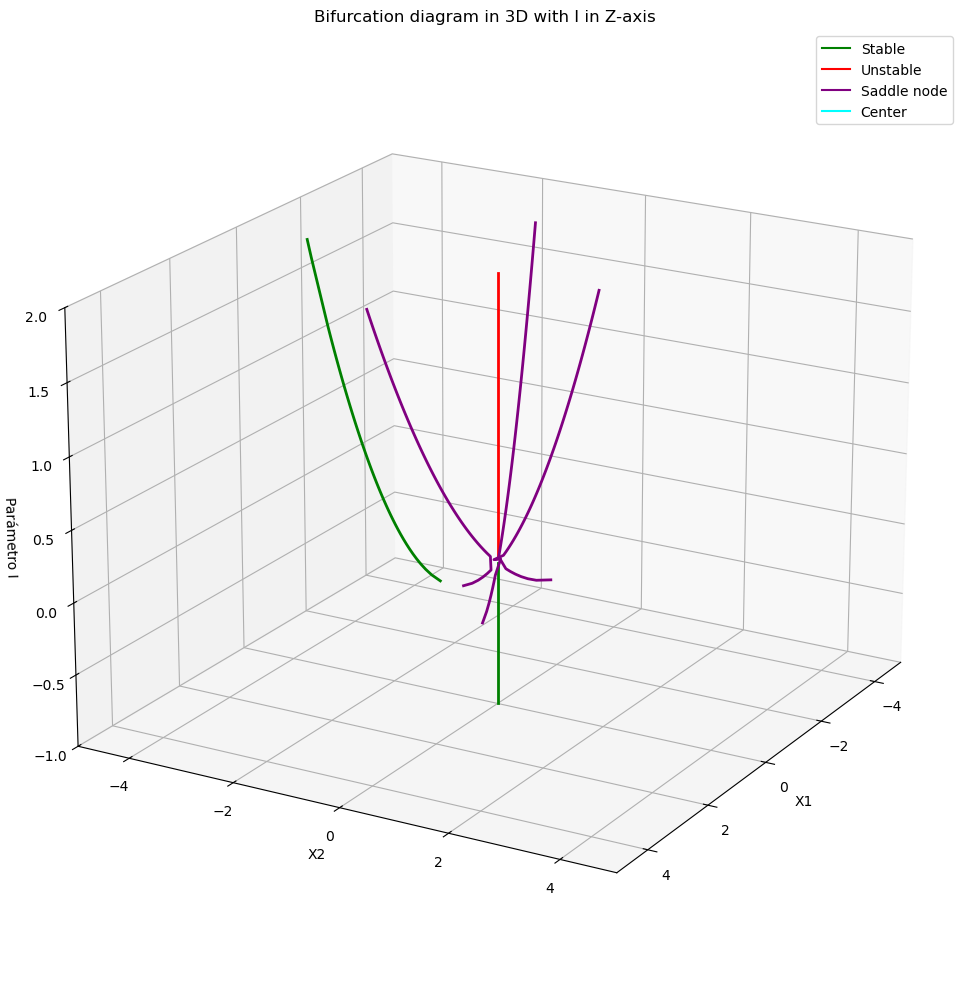

In [10]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

# Función para crear el diagrama de bifurcación 3D con líneas e I en el eje Z
def diagrama_bifurcacion_3d_lineas(I_min=-2.0, I_max=2.0, num_I_values=100):
    """
    Crea un diagrama de bifurcación 3D con líneas que muestra cómo evolucionan 
    los puntos de equilibrio respecto al parámetro I, con I en el eje Z.
    """
    I_values = np.linspace(I_min, I_max, num_I_values)
    
    # Diccionario para almacenar las ramas de equilibrio
    ramas = {
        'stable': [],
        'unstable': [],
        'saddle': [],
        'center': []
    }
    
    # Para cada valor de I, encontramos los puntos de equilibrio
    for i, I in enumerate(I_values):
        print(f"Procesando I = {I}")
        equilibrios = encontrar_equilibrios(I)
        
        # Si es el primer valor de I, inicializamos las ramas
        if i == 0:
            for j, eq in enumerate(equilibrios):
                estabilidad = determinar_estabilidad(eq, I)
                
                if "stable" in estabilidad and "unstable" not in estabilidad:
                    ramas['stable'].append({'puntos': [(eq[0], eq[1], I)], 'id': f'estable_{j}'})
                elif "unstable" in estabilidad:
                    ramas['unstable'].append({'puntos': [(eq[0], eq[1], I)], 'id': f'inestable_{j}'})
                elif "saddle" in estabilidad:
                    ramas['saddle'].append({'puntos': [(eq[0], eq[1], I)], 'id': f'silla_{j}'})
                else:
                    ramas['center'].append({'puntos': [(eq[0], eq[1], I)], 'id': f'centro_{j}'})
        else:
            # Para cada equilibrio, buscamos la rama más cercana del mismo tipo
            for eq in equilibrios:
                estabilidad = determinar_estabilidad(eq, I)
                tipo = None
                
                if "stable" in estabilidad and "unstable" not in estabilidad:
                    tipo = 'stable'
                elif "unstable" in estabilidad:
                    tipo = 'unstable'
                elif "saddle" in estabilidad:
                    tipo = 'saddle'
                else:
                    tipo = 'center'
                
                # Buscamos la rama más cercana del mismo tipo
                min_dist = float('inf')
                rama_cercana = None
                
                for rama in ramas[tipo]:
                    # Último punto de la rama
                    ultimo_punto = rama['puntos'][-1]
                    x1_ultimo, x2_ultimo, _ = ultimo_punto
                    
                    # Calculamos la distancia
                    dist = np.sqrt((eq[0] - x1_ultimo)**2 + (eq[1] - x2_ultimo)**2)
                    
                    if dist < min_dist:
                        min_dist = dist
                        rama_cercana = rama
                
                # Si encontramos una rama cercana, añadimos el punto
                if rama_cercana is not None and min_dist < 1.0:  # Umbral de distancia
                    rama_cercana['puntos'].append((eq[0], eq[1], I))
                else:
                    # Si no, creamos una nueva rama
                    nuevo_id = f'{tipo}_{len(ramas[tipo])}'
                    ramas[tipo].append({'puntos': [(eq[0], eq[1], I)], 'id': nuevo_id})
    
    # Creamos el diagrama de bifurcación 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Colores para cada tipo de estabilidad
    colores = {
        'stable': 'green',
        'unstable': 'red',
        'saddle': 'purple',
        'center': 'cyan'
    }
    
    # Dibujamos cada rama como una línea 3D
    for tipo, lista_ramas in ramas.items():
        for rama in lista_ramas:
            puntos = rama['puntos']
            if len(puntos) > 1:  # Solo dibujamos si hay al menos 2 puntos
                X1_rama = [p[0] for p in puntos]
                X2_rama = [p[1] for p in puntos]
                I_rama = [p[2] for p in puntos]
                
                # Ordenamos los puntos por I
                idx = np.argsort(I_rama)
                X1_rama = [X1_rama[i] for i in idx]
                X2_rama = [X2_rama[i] for i in idx]
                I_rama = [I_rama[i] for i in idx]
                
                ax.plot(X1_rama, X2_rama, I_rama, '-', color=colores[tipo], linewidth=2)
            elif len(puntos) == 1:  # Si solo hay un punto, lo dibujamos como un punto
                ax.scatter(puntos[0][0], puntos[0][1], puntos[0][2], color=colores[tipo], s=30)
    
    # Configuramos los ejes
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Parámetro I')
    
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(I_min, I_max)
    
    # Añadimos una leyenda
    ax.plot([], [], '-', color='green', label='Stable')
    ax.plot([], [], '-', color='red', label='Unstable')
    ax.plot([], [], '-', color='purple', label='Saddle node')
    ax.plot([], [], '-', color='cyan', label='Center')
    ax.legend()
    
    # Configuramos la vista para una mejor visualización
    ax.view_init(elev=20, azim=30)
    
    plt.title('Bifurcation diagram in 3D with I in Z-axis')
    plt.tight_layout()
    plt.savefig('diagrama_bifurcacion_3d_lineas_I_en_Z.png', dpi=300)
    plt.show()

# Ejemplo de uso
diagrama_bifurcacion_3d_lineas(I_min=-1.0, I_max=2.0, num_I_values=100)